<a href="https://colab.research.google.com/github/Cloudydesuu/AITrainnning/blob/main/UCI_HAR_GridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint, loguniform

In [17]:
# Stage 1: Define the base directory for the dataset
# The dataset is the UCI Human Activity Recognition (HAR) dataset, stored in a specific directory
base_dir = "/kaggle/input/ucihar-dataset/UCI-HAR Dataset"

# Stage 2: Define a function to load data
# This function reads feature data (X) and labels (y) from text files, assuming whitespace-separated values
def load_data(X_path, y_path):
    X = pd.read_csv(X_path, delim_whitespace=True, header=None)  # Load feature data
    y = pd.read_csv(y_path, delim_whitespace=True, header=None)[0]  # Load labels (first column)
    return X, y


In [18]:
# Stage 3: Load training and testing data
# Load the training and testing feature data (X) and labels (y) from their respective files
X_train, y_train = load_data(f'{base_dir}/train/X_train.txt', f'{base_dir}/train/y_train.txt')
X_test, y_test = load_data(f'{base_dir}/test/X_test.txt', f'{base_dir}/test/y_test.txt')

# Stage 4: Load activity labels and feature names
# Read activity labels (e.g., walking, sitting) and feature names from text files
activity_labels = pd.read_csv(f'{base_dir}/activity_labels.txt', sep='\s+', header=None, names=['id', 'label'])
features = pd.read_csv(f'{base_dir}/features.txt', sep='\s+', header=None, names=['id', 'name'])

# Stage 5: Assign feature names to training and testing data
# Set the column names of X_train and X_test to the feature names for better interpretability
X_train.columns = X_test.columns = features['name']

# Stage 6: Map numerical labels to activity names
# Convert numerical labels (e.g., 1, 2) to descriptive activity names (e.g., WALKING, SITTING) for readability
y_train_names = y_train.map(dict(zip(activity_labels['id'], activity_labels['label'])))
y_test_names = y_test.map(dict(zip(activity_labels['id'], activity_labels['label'])))

# Stage 7: Standardize the feature data
# Scale the feature data to have zero mean and unit variance, which is necessary for some models (e.g., SVM, MLP, KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training data
X_test_scaled = scaler.transform(X_test)  # Transform testing data using the same scaler

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-90644515.py:8: SyntaxWarning: invalid escape sequence '\s'
  activity_labels = pd.read_csv(f'{base_dir}/activity_labels.txt', sep='\s+', header=None, names=['id', 'label'])
/tmp/ipython-input-90644515.py:9: SyntaxWarning: invalid escape sequence '\s'
  features = pd.read_csv(f'{base_dir}/features.txt', sep='\s+', header=None, names=['id', 'name'])
/tmp/ipython-input-889433696.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X = pd.read_csv(X_path, delim_whitespace=True, header=None)  # Load feature data
/tmp/ipython-input-889433696.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` in

In [19]:
# Stage 8: Define machine learning models and hyperparameter grids
# Create a dictionary of models and their hyperparameter distributions for RandomizedSearchCV
models = {
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": randint(3, 20),  # Depth of the tree
            "min_samples_leaf": randint(1, 10)  # Minimum samples per leaf
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": randint(50, 200),  # Number of trees
            "max_depth": randint(3, 20),
            "min_samples_leaf": randint(1, 10)
        }
    },
    "SVM": {
        "model": SVC(random_state=42),
        "params": {
            "C": loguniform(1e-3, 1e3),  # Regularization parameter
            "kernel": ['linear', 'rbf'],  # Kernel type
            "gamma": ['scale', 'auto'] + list(loguniform(1e-4, 1e-1).rvs(5))  # Kernel coefficient
        }
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {}  # No hyperparameters to tune
    },
    "MLP": {
        "model": MLPClassifier(max_iter=300, random_state=42),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (100, 50), (50, 50)],  # Layer configurations
            "activation": ['relu', 'tanh'],  # Activation functions
            "solver": ['adam', 'sgd'],  # Optimizers
            "alpha": loguniform(1e-5, 1e-1),  # L2 regularization
            "learning_rate_init": loguniform(1e-4, 1e-2)  # Initial learning rate
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": randint(3, 15)  # Number of neighbors
        }
    },
    "GBM": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": randint(50, 200),  # Number of boosting stages
            "max_depth": randint(3, 10),
            "learning_rate": loguniform(1e-3, 1e-1)
        }
    }
}


Best parameters for Decision Tree: {'max_depth': 6, 'min_samples_leaf': 8}

Decision Tree
                    precision    recall  f1-score   support

           WALKING       0.86      0.93      0.90       496
  WALKING_UPSTAIRS       0.88      0.73      0.80       471
WALKING_DOWNSTAIRS       0.75      0.83      0.79       420
           SITTING       0.89      0.70      0.78       491
          STANDING       0.77      0.92      0.84       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.86      2947
         macro avg       0.86      0.85      0.85      2947
      weighted avg       0.86      0.86      0.85      2947



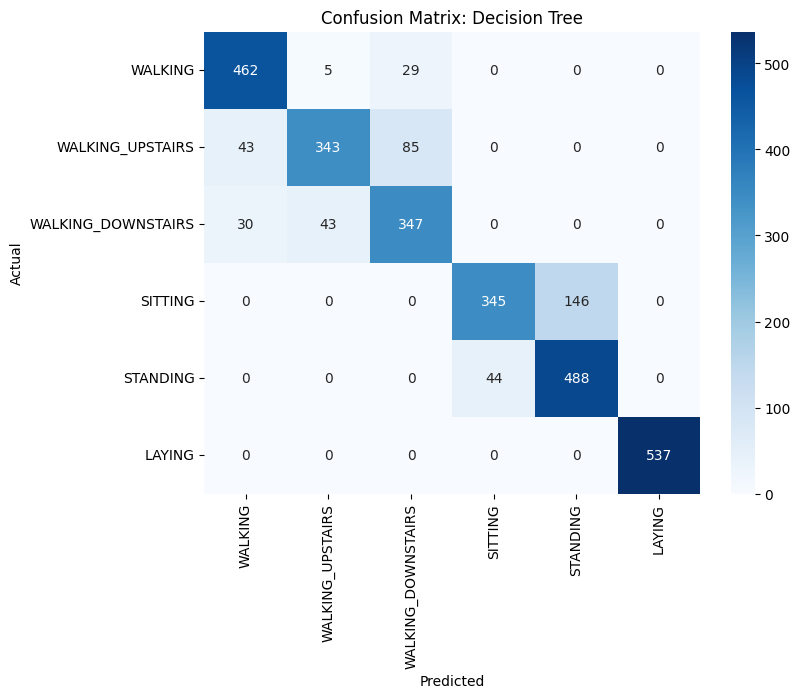


Best parameters for Random Forest: {'max_depth': 17, 'min_samples_leaf': 8, 'n_estimators': 70}

Random Forest
                    precision    recall  f1-score   support

           WALKING       0.88      0.97      0.93       496
  WALKING_UPSTAIRS       0.90      0.91      0.90       471
WALKING_DOWNSTAIRS       0.96      0.84      0.90       420
           SITTING       0.94      0.89      0.91       491
          STANDING       0.90      0.94      0.92       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947



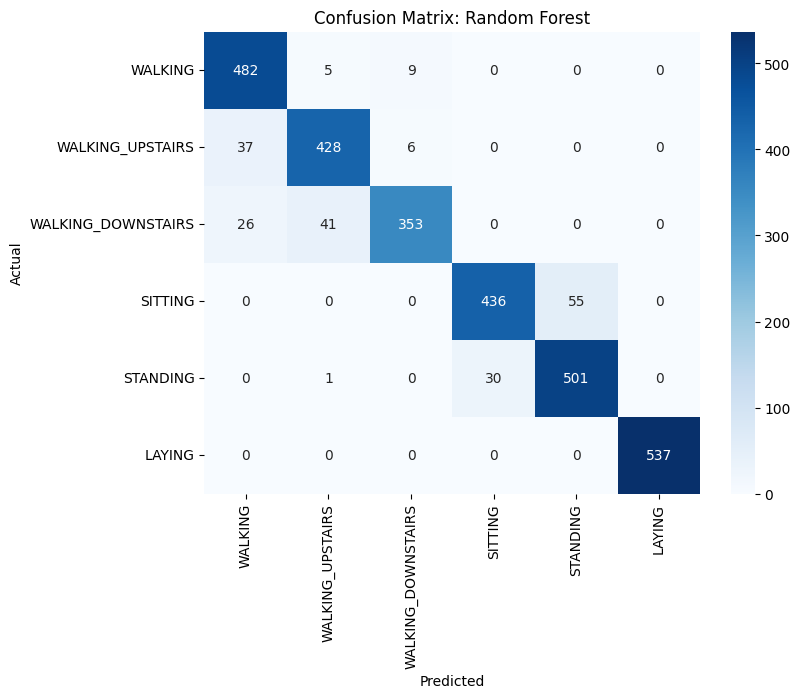


Best parameters for SVM: {'C': np.float64(0.1767016940294795), 'gamma': np.float64(0.0018049870691290806), 'kernel': 'linear'}

SVM
                    precision    recall  f1-score   support

           WALKING       0.96      1.00      0.98       496
  WALKING_UPSTAIRS       0.96      0.96      0.96       471
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
           SITTING       0.96      0.89      0.92       491
          STANDING       0.91      0.97      0.94       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



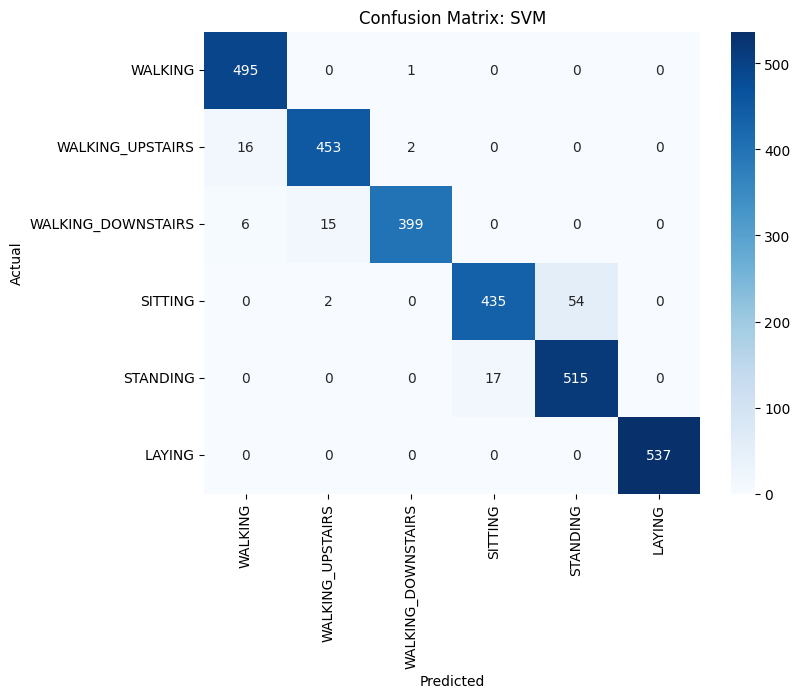


Naive Bayes
                    precision    recall  f1-score   support

           WALKING       0.82      0.84      0.83       496
  WALKING_UPSTAIRS       0.76      0.96      0.84       471
WALKING_DOWNSTAIRS       0.83      0.61      0.70       420
           SITTING       0.58      0.75      0.65       491
          STANDING       0.80      0.86      0.83       532
            LAYING       0.96      0.60      0.74       537

          accuracy                           0.77      2947
         macro avg       0.79      0.77      0.77      2947
      weighted avg       0.79      0.77      0.77      2947



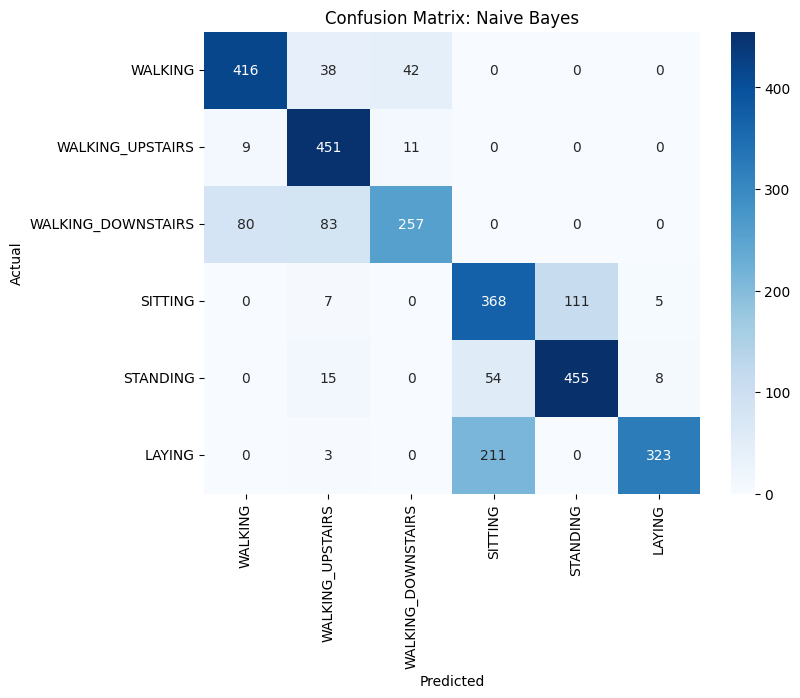


Best parameters for MLP: {'activation': 'relu', 'alpha': np.float64(0.07579479953348005), 'hidden_layer_sizes': (50, 50), 'learning_rate_init': np.float64(0.007535384509295544), 'solver': 'sgd'}

MLP
                    precision    recall  f1-score   support

           WALKING       0.93      0.99      0.96       496
  WALKING_UPSTAIRS       0.94      0.93      0.93       471
WALKING_DOWNSTAIRS       0.97      0.92      0.94       420
           SITTING       0.97      0.88      0.93       491
          STANDING       0.89      0.98      0.93       532
            LAYING       1.00      0.98      0.99       537

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



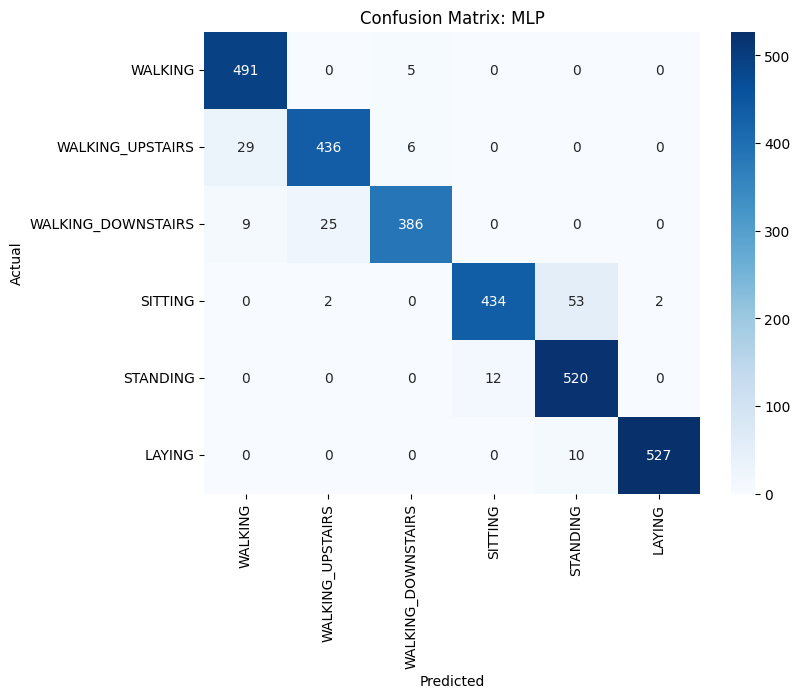


Best parameters for KNN: {'n_neighbors': 13}

KNN
                    precision    recall  f1-score   support

           WALKING       0.83      0.98      0.90       496
  WALKING_UPSTAIRS       0.88      0.90      0.89       471
WALKING_DOWNSTAIRS       0.98      0.74      0.84       420
           SITTING       0.90      0.77      0.83       491
          STANDING       0.80      0.95      0.87       532
            LAYING       0.99      0.95      0.97       537

          accuracy                           0.89      2947
         macro avg       0.90      0.88      0.88      2947
      weighted avg       0.90      0.89      0.89      2947



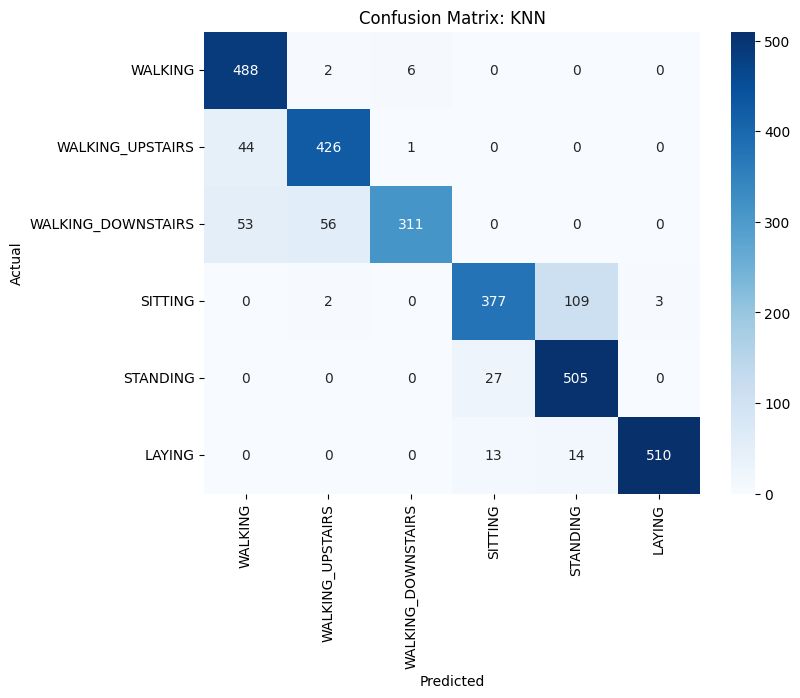


Best parameters for GBM: {'learning_rate': np.float64(0.01717762111233838), 'max_depth': 4, 'n_estimators': 71}

GBM
                    precision    recall  f1-score   support

           WALKING       0.85      0.96      0.90       496
  WALKING_UPSTAIRS       0.91      0.85      0.88       471
WALKING_DOWNSTAIRS       0.93      0.87      0.90       420
           SITTING       0.89      0.79      0.84       491
          STANDING       0.83      0.91      0.87       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.90      2947
         macro avg       0.90      0.90      0.90      2947
      weighted avg       0.90      0.90      0.90      2947



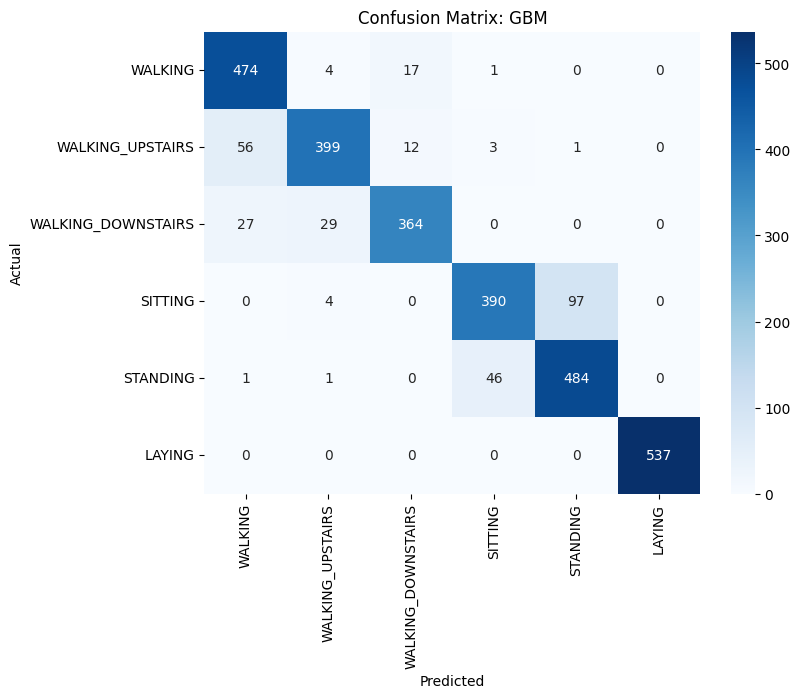

               accuracy  precision    recall        f1         time
SVM            0.961656   0.962595  0.961656  0.961534    17.236846
MLP            0.948083   0.949962  0.948083  0.948017    36.172429
Random Forest  0.928741   0.930338  0.928741  0.928448    12.432492
GBM            0.898541   0.900919  0.898541  0.898129  3056.483597
KNN            0.888022   0.896820  0.888022  0.886908     1.383960
Decision Tree  0.855786   0.861755  0.855786  0.854261     7.423410
Naive Bayes    0.770275   0.794683  0.770275  0.768770     0.046331


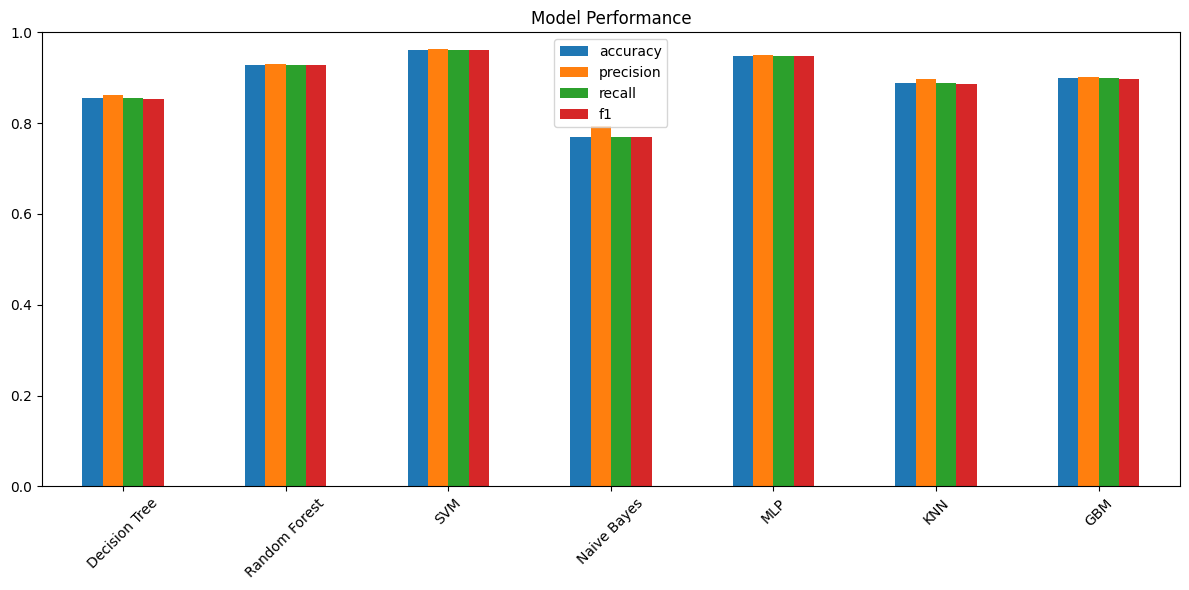

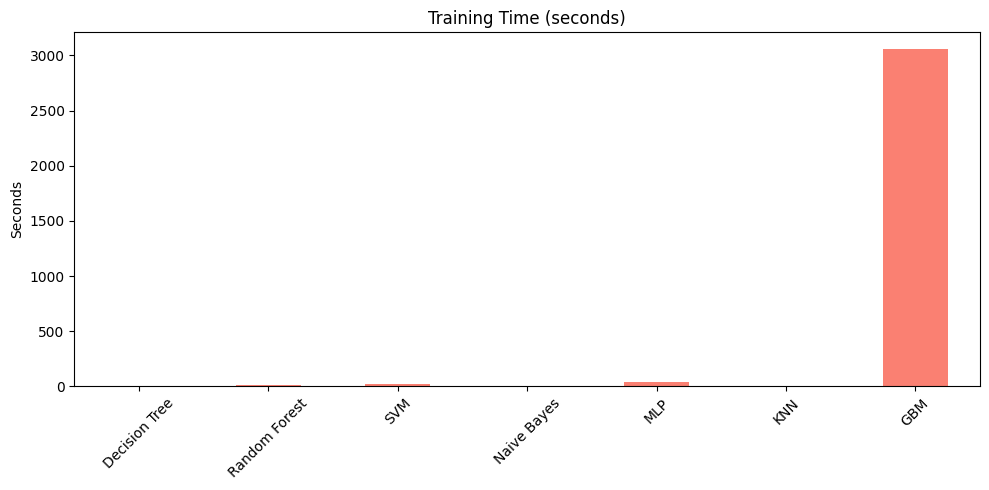

In [20]:
# Stage 9: Train and evaluate models with hyperparameter tuning
# Dictionary to store evaluation metrics for each model
results = {}

for name, model_info in models.items():
    start = time.time()  # Record start time for training

    # Get model and parameter grid
    model = model_info["model"]
    param_dist = model_info["params"]

    # Use scaled data for SVM, MLP, and KNN; unscaled data for others
    X_train_data = X_train_scaled if name in ["SVM", "MLP", "KNN"] else X_train
    X_test_data = X_test_scaled if name in ["SVM", "MLP", "KNN"] else X_test

    # Perform hyperparameter tuning if parameters are defined
    if param_dist:
        search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            n_iter=10,  # Number of parameter settings sampled
            cv=3,  # 3-fold cross-validation
            scoring='accuracy',
            random_state=42,
            n_jobs=-1  # Use all available cores
        )
        search.fit(X_train_data, y_train)
        best_model = search.best_estimator_
        print(f"\nBest parameters for {name}: {search.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train_data, y_train)

    # Predict using the best model
    y_pred = best_model.predict(X_test_data)

    end = time.time()  # Record end time for training

    # Store evaluation metrics: accuracy, precision, recall, F1-score, and training time
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "f1": f1_score(y_test, y_pred, average='weighted', zero_division=0),
        "time": end - start
    }

    # Stage 10: Print classification report
    # Display detailed performance metrics for each activity class
    print(f"\n{name}\n{classification_report(y_test, y_pred, target_names=activity_labels['label'])}")

    # Stage 11: Plot confusion matrix
    # Visualize the confusion matrix as a heatmap to show prediction performance
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=activity_labels['label'],
                yticklabels=activity_labels['label'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Stage 12: Summarize and display model performance
# Convert results dictionary to a DataFrame and sort by accuracy
df = pd.DataFrame(results).T
print(df.sort_values("accuracy", ascending=False))

# Stage 13: Plot model performance metrics
# Create a bar plot comparing accuracy, precision, recall, and F1-score across models
df[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', figsize=(12, 6), title="Model Performance")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Stage 14: Plot training times
# Create a bar plot showing the training time for each model
df['time'].plot(kind='bar', figsize=(10, 5), color='salmon', title="Training Time (seconds)")
plt.ylabel("Seconds")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()